# Выбор таргета

IS_SELLER - наш кандидат на таргет. Возможно именно факт победы в аукционе можно считать истинным отражением релевантности поставщика заказчику.
Построив рекомендательную систему на основе такого таргета, мы будем рекомендовать заказчику тех поставщиков, которые с наибольшей вероятностью выиграют в аукционе.

В идеале я хочу рекомендовать:
1. Наиболее подходящих по области к запросу. Тех, кто исполнял похожие заказы (нужна матрица заказ-поставщик, но в отрыве от поставщика она ничего не дает, у нас в датасете сто тысяч уже законченных запросов, рекоммендовать к ним что-либо бессмысленно, а для новых возникает проблема холодного старта). Лучше использовать запрос в качестве фичей для контеного метода.
2. Наиболее честных и наименее рискованных. Можно поизвлекать признаки из аггрегаций по флагам в трейне.
3. Предлагающих наилучшие условия по деньгам. (Мы можем, например, кластеризовать заказы по описаниям или объемам, и для каждого кластера насчитать средние по финальным и начальным ценам. Определяя кластер заказа в запросе, мы можем понять, какое значение фичи подтянуть)
4. Тех, кто при всем этом действительно выиграет аукцион.

Я могу построить три рекомендательных системы: на цену, на безопасность и на победу в аукционе
А их скоры выдавать с весами, которые задает пользователь сам.

# Обучение модели

## Подрузка данных

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pathlib
import rectools

from sklearn.model_selection import train_test_split

In [9]:
data_path = pathlib.Path("../data/")

offers = pd.read_csv(data_path / "d_offer.csv")
lots = pd.read_csv(data_path / "d_lot.csv")
lots_prods = pd.read_csv(data_path / "d_lot_prod.csv")
persons = pd.read_csv(data_path / "d_person.csv")

df_train = pd.read_csv(data_path / "all_ids_train.csv")

In [10]:
def get_merged_data(df):
    merged_df = pd.merge(df, offers, left_on=["OFFER_ID", "LOT_ID"], right_on=["OFFER_ID", "LOT_ID"], how="left") # джойним к логам офферы
    merged_df = pd.merge(merged_df, persons, left_on="OFFER_PERSON_ID", right_on="PERSON_ID", how="left").drop("PERSON_ID", axis=1)
    merged_df = pd.merge(merged_df, persons, left_on="BUYER_PERSON_ID", right_on="PERSON_ID", suffixes=("_OFFER", "_BUYER")).drop("PERSON_ID", axis=1) # джойним к поставщикам и заказчикам их города
    
    merged_df = pd.merge(merged_df, lots, on="LOT_ID", how="left") # джойним лоты
    # merged_df = pd.merge(merged_df, lots_prods, on="LOT_ID", how="left") # джойним продукты в лотах, там целый список с количествами
    return merged_df

merged_df = get_merged_data(df_train)

Отфильтруем странные контракты с установленными флагами

In [11]:
from functools import reduce

flags_list = ["CANCELLED_FLAG", "INCONSISTENT_FLAG", "UNCONSIDERED_FLAG", "REJECT_FLAG", "CUSTOMER_REFUSAL_FLAG"]

any_flag_filter = reduce(lambda x, y : x | y, map(lambda f: merged_df[f] == 1, flags_list))

merged_df = merged_df[~merged_df["IS_SELLER"] | ~any_flag_filter]

Посмотрим на распределение таргета

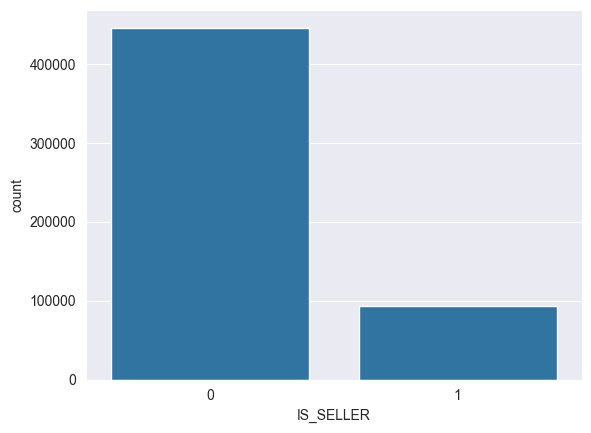

In [35]:
sns.barplot(merged_df["IS_SELLER"].value_counts())
plt.show()

Для коллаборативной фильтрации достаточно иметь только матрицу: Заказчик - поставщик - факт заключения контракта

## 1. Таргет - факт заключения контракта

### Подготовим данные

Мы проставим 1, если поставщик выиграл у заказчика хотя бы один лот


In [12]:
from rectools import Columns

base_columns = ["OFFER_PERSON_ID","BUYER_PERSON_ID", "IS_SELLER"]

df_all = merged_df[base_columns]
df_all = df_all[df_all["OFFER_PERSON_ID"] != -1]
df_all = df_all.rename(columns={
    "BUYER_PERSON_ID": Columns.User,
    "OFFER_PERSON_ID": Columns.Item,
    "IS_SELLER": Columns.Weight
})
df_all[Columns.Datetime] = -1

df = df_all.groupby([Columns.User, Columns.Item]).max().reset_index()
df.head()

,user_id,item_id,weight,datetime
0,8,12,1,-1
1,8,214,0,-1
2,8,725,1,-1
3,8,762,0,-1
4,8,918,0,-1


Посмотрим на распределение числа интеракиций заказчиков

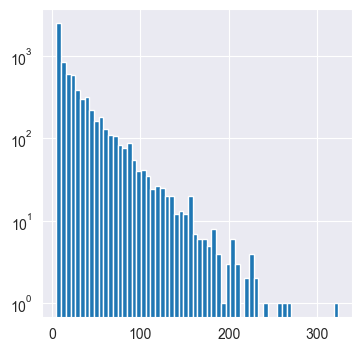

In [13]:
interactions_count = df.groupby(Columns.User)[Columns.Item].count()

fig, ax = plt.subplots(figsize=(4,4))
plt.hist(interactions_count, bins=60, log=True)
plt.show()

In [14]:
interactions_count.describe()

count    7035.000000
mean       29.497655
std        32.749909
min         5.000000
25%         7.000000
50%        17.000000
75%        39.000000
max       324.000000
Name: item_id, dtype: float64

Видим, что есть заказчики с большим числом интеракций с разными поставщиками, но при этом подавляющее большинство среди них взаимодействовало с совсем небольшим количеством поставщиков.

Оценим распределение на общее число интеракций, а не только с уникальными поставщиками.

[]

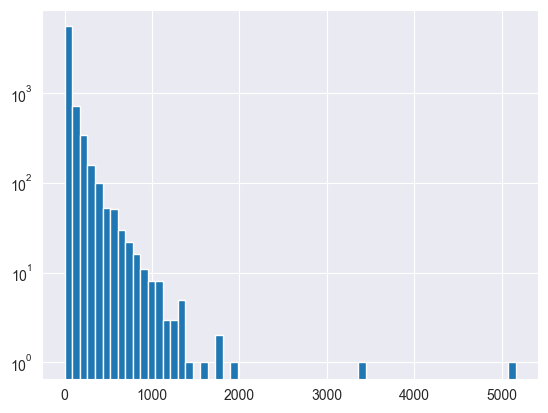

In [15]:
interactions_count_all = df_all.groupby(Columns.User)[Columns.Item].count()

plt.hist(interactions_count_all, bins=60, log=True)
plt.plot()

In [16]:
interactions_count_all.describe()

count    7035.000000
mean       76.766596
std       160.132804
min         5.000000
25%         8.500000
50%        25.000000
75%        75.000000
max      5160.000000
Name: item_id, dtype: float64

На общее число интеракций у нас вообще гигантский разброс.
Кажется, это связано с тем, что на рынке есть игроки совершенно разного масштаба: крупные компании делают заказы постоянно.

Определим холодных юзеров. Мы сможем сделать по ним срез данных.
С учетом квантиля в 25% на 8.5 будем считать юзера холодным, если у него <= 8 интеракций

In [17]:
cold_user_threshold = 8
df_all = pd.merge(df_all, interactions_count_all <= cold_user_threshold, left_on=Columns.User, right_on=Columns.User, how="left").rename(columns={Columns.Item + "_y": "is_cold", Columns.Item + "_x": Columns.Item})

cold_user_threshold_unique = 6
df = pd.merge(df, interactions_count <= cold_user_threshold_unique, left_on=Columns.User, right_on=Columns.User, how="left").rename(columns={Columns.Item + "_y": "is_cold", Columns.Item + "_x": Columns.Item})

In [18]:
df_train, df_test = train_test_split(df_all, train_size=0.8, random_state=72) 

df_test = df_test[df_test[Columns.User].isin(df_train[Columns.User])]

Разделили данные случайно (так как не имеем временных меток) и отфильтровали по юзеру

### Модель Popular

Будем считать поставщика популярным, если к нему обращаются много разных заказчиков.

In [19]:
from rectools.models import PopularModel
from rectools.dataset import Dataset

model = PopularModel(
    popularity="n_users", # mean_weight, sum_weight, n_interactions
    verbose=1
)
# количество взаимодействий не равно количеству пользователей, так что один юзер мог взаимодействовать несколько раз с разными эффектами
model.fit(Dataset.construct(df_train))

#### Оценка качества

Метрики ранжирования:
1. Precision@k, MeanAveragePrecision, nDCG

Метрики рекомендаций:
1. Diversity, novelty, coverage, serendipity

К сожалению, в рамках курсача невозможно оценить бизнес-метрики

##### 1. Метрики ранжирования

Сначала избавимся от одинаковых интеракций с разными результами, оставив толькос амую успешную для каждлого поставщика

In [20]:
df_test = df_test.groupby([Columns.User, Columns.Item]).max().reset_index()
df_test.head()

,user_id,item_id,weight,datetime,is_cold
0,8,12,0,-1,False
1,8,1297,1,-1,False
2,8,1413,0,-1,False
3,8,1613,0,-1,False
4,8,2415,1,-1,False


In [21]:
recs = model.recommend(
    users=df_test[Columns.User].unique(),
    dataset=Dataset.construct(df_test),
    k=10,
    filter_viewed=False
)
recs

  0%|          | 0/6389 [00:00<?, ?it/s]

,user_id,item_id,score,rank
0,8,10023,2207.0,1
1,8,2914,2020.0,2
2,8,2262,1853.0,3
3,8,3114,1311.0,4
4,8,1613,1290.0,5
...,...,...,...,...
63885,25034,4523,1186.0,6
63886,25034,4001,1091.0,7
63887,25034,3808,1058.0,8
63888,25034,5731,1051.0,9


In [22]:
def score(metric, recs, df):
    cold_users = df[Columns.User][df["is_cold"]]
    cold_users_filter = recs[Columns.User].isin(cold_users)
    
    res = {}
    res["cold"] = metric.calc(recs[cold_users_filter], df[df["is_cold"]])
    res["hot"] = metric.calc(recs[~cold_users_filter], df[~df["is_cold"]])
    res["all"] = metric.calc(recs, df)
    return res

In [29]:
from rectools.metrics.ranking import MAP, NDCG

# Precision@k по всем позициям с 1

pd.DataFrame([
    score(MAP(k=10), recs, df_test),
    score(NDCG(k=10), recs, df_test)
], index=["MAP", "NDCG"])

,cold,hot,all
MAP,0.000718,0.002149,0.001876
NDCG,0.000389,0.010339,0.008447


Конечно, с такими метриками мы не будем использовать эту модель в качестве итоговой, но возможно она станет моделью первого уровня.

Установим k=1000, и теперь вручную переберем тип нашей рекомендательной системы:

In [40]:
for model_type in ["n_users", "n_interactions"]:
    k=1000
    
    model = PopularModel(
        popularity=model_type,
        verbose=False
    )
    model.fit(Dataset.construct(df_train))
    recs = model.recommend(
        users=df_test[Columns.User].unique(),
        dataset=Dataset.construct(df_test),
        k=k,
        filter_viewed=False
    )
    scores = pd.DataFrame([
        score(MAP(k=k), recs, df_test),
        score(NDCG(k=k), recs, df_test)
    ], index=["MAP", "NDCG"])
    print(f"{model_type}:")
    print(scores)

n_users:
          cold       hot       all
MAP   0.003096  0.012510  0.010720
NDCG  0.000432  0.007018  0.005765
n_interactions:
          cold       hot       all
MAP   0.002815  0.012542  0.010692
NDCG  0.000436  0.007195  0.005910


##### 2. Метрики рекомендаций

Для метрики ILS для оценки разнообразия 

In [ ]:
from rectools.metrics.distances import PairwiseDistanceCalculator
from rectools.metrics import IntraListDiversity

### ALS

1. IALS (+написать инференс на новых объектах) с разными таргетами
2. IALS + контентные фичи

Что я хочу попробовать в качестве скоров:
1. Классический ALS, где 1 - это участвовал и выиграл, а 0 - это участвовал, но проиграл
2. Классический IALS, где мы оценим заключение контракта как 10, участие как 5, а остальное как 0. Можно еще число выигранных лотов поставить
3. Эксперименты со скорами IALS по другим фичам

# Вопросы

1. Приходит новая заявка. Как решить, кого к ней рекомендовать? Кажется, коллаборативная фильтрация на основе факторизаций использует только историю взаимодейтсвия юзера и умноженгие на трейновую матрицу. Там ничего переучивать не надо.
Другое ли дело, что с появлением большого числа новых юзеров тренды могут изменитсья и модель нужно все же переучить

2. Какие фичи использовать? Если мой бустинг использует флаги, то, даже зная всех участников аукциона, я не предскажу победителя. Можем просто посчитать среднее число флагов как фичу.
Но хочется учесть, какие именно контракты приводят к таким флагам. Можно поделать 

К поставщику проще, чем к заявке?
SML - метод последовательного метаобучения https://paperswithcode.com/paper/how-to-retrain-recommender-system-a
